The correlation functions from this computation looks wrong. I'm gonna look at them and figure out why :( 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [2]:
import numpy as np
from glob import glob
from os import path

In [3]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat/'

In [4]:
outputs = sorted(glob(path.join(output_dir, 'xi_gg_gm_darksky_obs_v8_???.npy')))

In [5]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5, 2*18)) # num bins and num HODs 

In [6]:
for i,output_file in enumerate(outputs):
    output = np.load(output_file)
    all_outputs[i] = output

In [7]:
r_bins = np.logspace(-1.1, 1.6, 19)
rpoints = (r_bins[1:]+r_bins[:-1])/2.0

In [8]:
all_outputs.shape

(1, 5, 36)

In [11]:
print all_outputs[0,0,:18]

[  5.23617320e+04   2.92842735e+04   1.57463530e+04   8.34535187e+03
   4.37330408e+03   2.22578937e+03   1.09930998e+03   5.08974511e+02
   2.19880163e+02   8.80789309e+01   3.34248278e+01   1.36426553e+01
   6.58832956e+00   3.44325309e+00   1.65681835e+00   5.97975471e-01
  -3.06498095e-02  -3.88894686e-01]


In [12]:
print all_outputs[0,0,18:]

[-491.72171276 -170.91076871  -12.89229487   44.30698783   66.52388333
   66.97679546   57.27685936   48.34518708   34.68788577   24.94844124
   16.8645739    10.83628546    7.1368162     4.67062499    3.21093771
    2.29883513    1.26971492    0.66626105]


[]

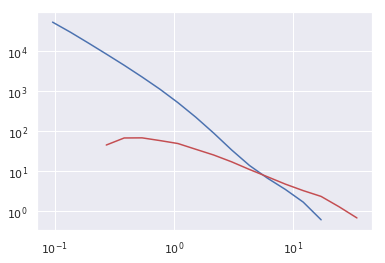

In [10]:
plt.plot(rpoints, all_outputs[0, 0, :18].T, color = 'b')
plt.plot(rpoints, all_outputs[0, 0, 18:].T, color = 'r')

plt.loglog()

In [11]:
from pearce.mocks.kittens import DarkSky
from pearce.mocks import tpcf
#from halotools.mock_observables import tpcf
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
import numpy as np
from collections import OrderedDict
from time import time
from scipy.optimize import minimize_scalar
import yaml
#import sys

In [12]:
randoms = np.load('/scratch/users/swmclau2/randoms_gm.npy')

In [14]:
randoms.shape[0]/100

2743973

In [11]:
config_fname = 'xi_cosmo_trainer.yaml'

RR = np.loadtxt(path.join(output_dir, 'RR.npy'))[0]

with open(path.join(output_dir, config_fname), 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

nd = float(cfg['HOD']['fixed_nd'] )
min_ptcl = int(cfg['HOD']['min_ptcl'])
r_bins = np.array(cfg['observation']['bins'] ).astype(float)

hod_param_ranges =  cfg['HOD']['ordered_params']


logMmin_bounds = hod_param_ranges['logMmin']


del hod_param_ranges['logMmin']

In [12]:
def make_LHC(ordered_params, N, seed = None):

    if seed is None:
        seed = int(time())
    np.random.seed(seed)

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T


def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl = min_ptcl) - nd)**2

    res = minimize_scalar(func, bounds = logMmin_bounds, args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [13]:
from pearce.mocks.kittens import TestBox
cat2 = TestBox(boxno = 0, realization = 0, system = 'sherlock')
print cat2.h

0.632317


In [14]:
def compute_obs(cat, rbins, randoms, RR=RR):#, rand_scalecut = 1.0 ,  n_rands= [10, 5, 5], n_sub = 3, RR=RR):
#np.random.seed(int(time()))

    n_cores = 1# cat._check_cores(4)#16)

    x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
#pos_g = return_xyz_formatted_array(x_g, y_g, z_g, period=cat.Lbox)
    pos_g = np.vstack([x_g, y_g, z_g]).T
    #x_m, y_m, z_m = [cat.halocat.ptcl_table[c] for c in ['x', 'y', 'z']]
    #pos_m = np.vstack([x_m, y_m, z_m]).T

    rbins = np.array(rbins)

    #cov_gg, cov_gg_gm, cov_gm = np.zeros((rbins.shape[0]-1, rbins.shape[0]-1))
    #cov = np.zeros((rbins.shape[0]-1, rbins.shape[0]-1))

    #for rb,idxs,  nr in zip([rbins_small,rbins_mid, rbins_large],\
    #                        [(0, len(rbins_small)), (boundary_idx-mid_size_ov2, boundary_idx+mid_size_ov2), len(rbins_small), len(rbins)],\
    #                        n_rands): #
#for rb, nr in zip([rbins_large], n_rands): #
    # nr removed
    orig_randoms_h = 0.632317
    xi_gg = tpcf(pos_g / cat.h, rbins,randoms=randoms*orig_randoms_h/cat.h, sample2 = None, period=None,
                          num_threads=n_cores, estimator='Landy-Szalay',\
                          do_auto1 = True, do_cross = False, RR_precomputed=RR, NR_precomputed=randoms.shape[0])#, do_auto2 = False)
    #xi_gg = tpcf(pos_g / cat.h, rbins, period=cat.Lbox/cat.h,
    #                      num_threads=n_cores, estimator='Landy-Szalay',\
    #                      do_auto = True, do_cross = False)#, RR_precomputed=RR, NR_precomputed=randoms.shape[0])#, do_auto2 = False)

    return xi_gg#np.r_[xi_gg, xi_gm]


In [15]:
# TODO seed here for constant HODs
# TODO maybe just do 5, 10 may be overkill
N = 10
LHC = make_LHC(hod_param_ranges, N, 24)
hod_dicts = [dict(zip(hod_param_ranges.keys(), vals)) for vals in LHC]

In [ ]:
randoms = np.load('/scratch/users/swmclau2/randoms_gm.npy')

obs_vals = np.zeros((512, N, 2*(len(r_bins)-1)))
#obs_vals = np.load('xi_gg_darksky_obs.npy')
from itertools import product
HOD = (Zheng07Cens, Zheng07Sats)

#b1, b2, b3 = sys.argv[1], sys.argv[2], sys.argv[3]
start_subbox = (0,0,0)#(b1,  b2, b3)

In [ ]:
start_idx = 64*int(start_subbox[0])+8*int(start_subbox[1])+int(start_subbox[2])
for subbox_idx, subbox in enumerate(product(''.join([str(i) for i in xrange(8)]), repeat = 3)):
    if subbox_idx < start_idx:
        continue
    print subbox
    cat = DarkSky(int(''.join(subbox)), system = 'sherlock')
    cat.load_model(1.0, HOD = HOD, hod_kwargs = {'modlulate_with_cenocc': True})
    cat.load_catalog_no_cache(1.0, min_ptcl=min_ptcl, particles = False)#, downsample_factor = 1e-2)
    for hod_idx, hod_params in enumerate(hod_dicts):
        print hod_idx,
        add_logMmin(hod_params, cat)
        cat.populate(hod_params, min_ptcl = min_ptcl)
        #sys.stdout.flush()
        obs = compute_obs(cat, r_bins, randoms, RR)
# TODO need to save all the outputs not just the last one dumdumdum 
        #obs_vals[subbox_idx, hod_idx] = obs
        #np.save('xi_gg_gm_darksky_obs_%s%s%s.npy'%(b1,b2,b3), obs.squeeze())
        #print 'Exiting.'
        #from sys import exit
        #exit(0)
        break
    break

('0', '0', '0')


/home/users/swmclau2/.local/lib/python2.7/site-packages/halotools/empirical_models/occupation_models/zheng07_components.py:323: UserWarning: You chose to input a ``cenocc_model``, but you set the 
``modulate_with_cenocc`` keyword to False, so your ``cenocc_model`` will have no impact on the model's behavior.
Be sure this is what you intend before proceeding.
Refer to the Zheng et al. (2007) composite model tutorial for details.

  warnings.warn(msg)


0

In [ ]:
cat2.h, cat.h

In [ ]:
rpoints = (r_bins[1:] + r_bins[:-1])/2.0
plt.plot(rpoints, obs.squeeze())
plt.loglog()